In [1]:
import jieba
import jieba.analyse
import os
import datetime
import pandas as pd
import tushare as ts
import gensim
import re
import sys
import seaborn as sns
import json
import enchant
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


ImportError: No module named enchant

In [174]:
sns.set_style("whitegrid")
sns.set_context("talk")

# 1、从新闻文本中统计词频

In [227]:
WALLSTCN_DIR = "C:/Users/jgtzsx01/Documents/workspace/data/wallstreetcn"
WORD_CNT_FILE = "C:/Users/jgtzsx01/Documents/workspace/data/wallstreetcn_word_count.json"
WALLSTCN_MODEL = "C:/Users/jgtzsx01/Documents/workspace/model/wallstreet_model"
ASSET_CLASS_DIR = "C:/Users/jgtzsx01/Documents/workspace/data/asset-class/"

In [30]:
with open("./stop_words_zh.txt", 'r') as f:
    stop_words = set([line.strip() for line in f.readlines()])

In [43]:
def isChinese(word):
    for w in word:
        if re.match('[ \u4e00 -\u9fa5]+',w) == None:
            continue
        else:
            return False
    return True

In [7]:
years = [y for y in os.listdir(WALLSTCN_DIR)]

In [8]:
years

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

In [318]:
with open(WORD_CNT_FILE, 'r') as fp:
    word_count = json.load(fp)

In [57]:
for y in years:
    files = ["%s/%s/%s"%(WALLSTCN_DIR, y, f) for f in os.listdir("%s/%s/"%(WALLSTCN_DIR, y))]
    print y, len(files)
    if len(files) > 0:
        for f in files:
            with open(f, 'r') as fp:
                text = fp.readlines()
            time, author, title = text[0].split('_')
            time = time.strip()
            dt = datetime.datetime.strptime(time, "%Y年%m月%d日 %H:%M:%S")
            date = dt.strftime("%Y-%m-%d")
            
            content = " ".join(text[1:])
            doc = [word for word in jieba.cut(content) if not word in stop_words]
            for word in doc:
                if not isChinese(word):
                    continue
                if not word_count.has_key(word):
                    word_count[word] = {}
                if not word_count[word].has_key(date):
                    word_count[word][date] = 0
                word_count[word][date] += 1

2010 0
2011 0
2012 0
2013 0
2014 0
2015 0
2016 4332
可是
2017 1378
中年


In [36]:
with open(WORD_CNT_FILE, 'w') as fp:
    json.dump(word_count, fp)

# 2、从词频度量关注度

In [321]:
with open(WORD_CNT_FILE, 'r') as fp:
    word_count = json.load(fp)

MemoryError: 

In [101]:
word_cnt = {}
for word in word_count.keys():
    word_cnt[word] = {}
    for date, count in word_count[word].iteritems():
        dt = datetime.datetime.strptime(date, "%Y-%m-%d")
        (year, week, _) = dt.isocalendar()
        key = "%d-%d"%(year, week)
        if not word_cnt.has_key(key):
            word_cnt[word][key] = 0
        word_cnt[word][key] += count

In [64]:
model = gensim.models.Word2Vec.load(WALLSTCN_MODEL)

In [305]:
key_word = u"货币"
asset_class = "money"
for w, v in model.most_similar(key_word, topn=15):
    if isChinese(w):
        print w, v

乘数 0.443531960249
货币量 0.435596168041
超发 0.425356328487
定值 0.425160884857
抵补 0.401408910751
货币政策 0.399002969265
篮子 0.393310844898
广义 0.391331315041
量体裁衣 0.388913214207
第五种 0.38616207242
盯住 0.383850991726
超增 0.382250458002
货币汇率 0.375666409731


In [306]:
# word_df = pd.DataFrame({"date": word_count[key_word].keys(), "count": word_count[key_word].values()})
# word_df.index = word_df["date"].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
# word_df.sort_index(inplace=True)

In [307]:
word_df = pd.DataFrame({"date": word_cnt[key_word].keys(), "count": word_cnt[key_word].values()})
word_df.index = word_df["date"].map(lambda x: datetime.datetime.strptime(x + '-0', "%Y-%W-%w"))
word_df.sort_index(inplace=True)

In [308]:
word_df.head()

,count,date
date,,
2016-06-19,2,2016-24
2016-08-07,31,2016-31
2016-08-14,39,2016-32
2016-10-09,10,2016-40
2016-11-06,24,2016-44


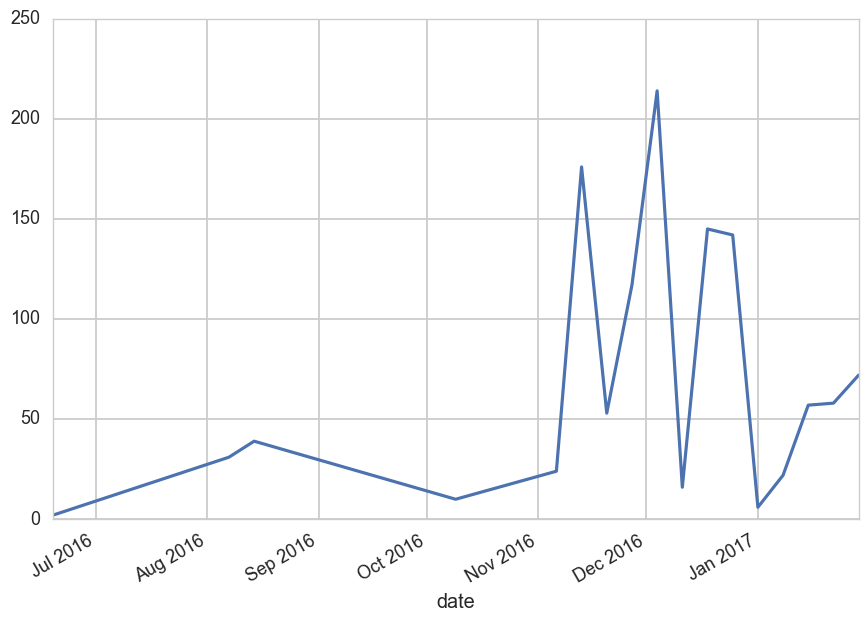

In [309]:
word_df["count"].plot()

In [310]:
mean, std = word_df["count"].mean(), word_df["count"].std()
word_df["zscore"] = (word_df["count"] - mean) / std

(array([ 736146.,  736177.,  736208.,  736238.,  736269.,  736299.,  736330.]),
 <a list of 7 Text xticklabel objects>)

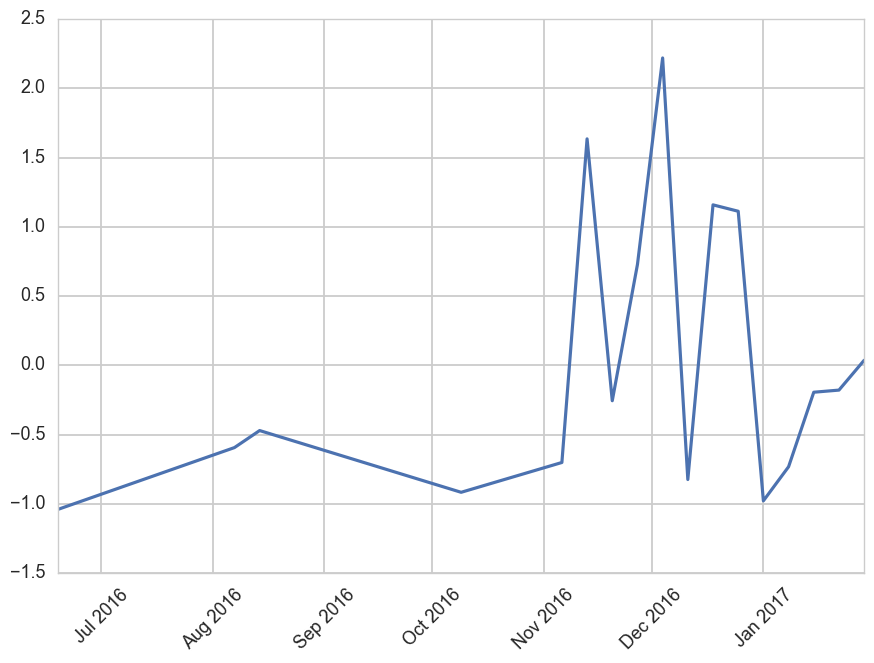

In [311]:
plt.plot(word_df.index, word_df['zscore'])
plt.xticks(rotation=45)

In [312]:
total_word_count = {}
for word in word_cnt:
    for day, value in word_cnt[word].iteritems():
        if not total_word_count.has_key(day):
            total_word_count[day] = 0
        total_word_count[day] += value * 1.0 / 10

In [313]:
hot_val = {}
threshold = 0.1
for word in word_cnt:
    if isChinese(word) and word in model.vocab:
        dis = model.similarity(word, key_word)
        if dis > threshold:
            for day, value in word_cnt[word].iteritems():
                if not hot_val.has_key(day):
                    hot_val[day] = 0
                hot_val[day] += value * dis
for key, value in hot_val.iteritems():
    hot_val[key] = value / total_word_count[key]

In [314]:
hot_df = pd.DataFrame({"date": hot_val.keys(), "value": hot_val.values()})
hot_df["date"] = hot_df["date"].map(lambda x: datetime.datetime.strptime(x + '-0', "%Y-%W-%w"))
hot_df.index = hot_df["date"]
# hot_df.index = hot_df["date"].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
hot_df.sort_index(inplace=True)

In [315]:
hot_df.head()

,date,value
date,,
2016-06-19,2016-06-19,0.189957
2016-08-07,2016-08-07,0.625182
2016-08-14,2016-08-14,0.573560
2016-09-04,2016-09-04,0.359408
2016-09-11,2016-09-11,0.405751


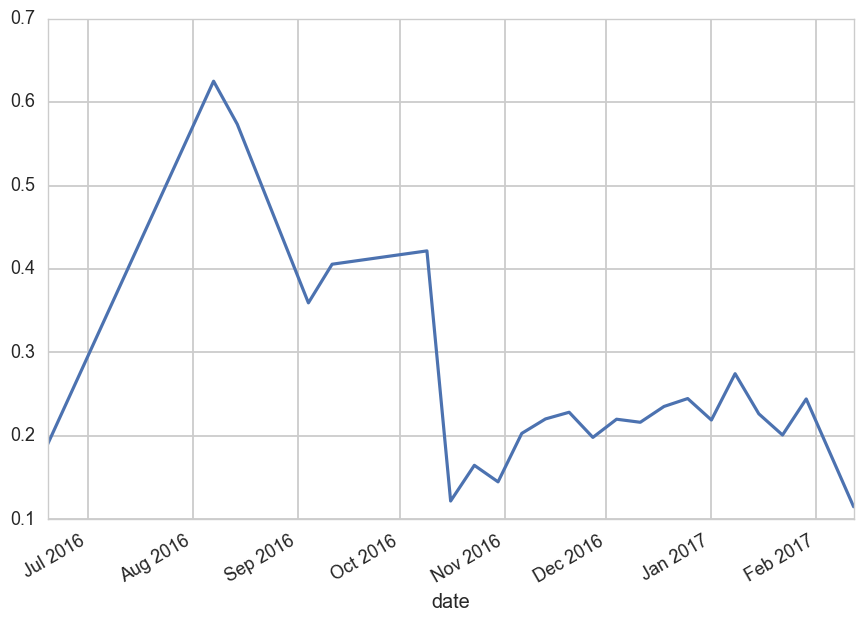

In [316]:
hot_df["value"].plot()

In [317]:
hot_df.to_csv("%s/%s.csv"%(ASSET_CLASS_DIR, asset_class), index=False)